In [1]:
import sys
sys.path.append('/home/twilliams/adaptation_abm/code')
import os
import model.model as mod
import model.base_inputs as inp
import plot.multi_scenario as plt_multi
import plot.single_run as plt_it
import matplotlib.pyplot as plt
import calibration.POM as POM
import experiments.multi_scenario_comparison as msc
import imp
import copy
import code
import tqdm
import numpy as np
import pickle
import copy
from joblib import Parallel, delayed
from tqdm import tqdm
import multiprocessing

In [8]:
nreps = 100
exp_name = '2019_10_15_4'
ncores = 40

# load default params
inp_base = inp.compile()
#### OR ####
# load from POM experiment
pom_nvars = 100000
pom_nreps = 10
f = '../../outputs/{}/POM/{}_{}reps/input_params_0.pkl'.format(exp_name, pom_nvars, pom_nreps)
inp_base = pickle.load(open(f, 'rb'))
# manually specify some variables (common to all scenarios)
T = 100
inp_base['model']['T'] = T
inp_base['model']['n_agents'] = 2000
inp_base['model']['exp_name'] = exp_name
inp_base['agents']['adap_type'] = 'always'

# inp_base['agents']['land_area_init'] = np.linspace(1,2,100)

#### adaptation scenarios
scenarios = {
    'baseline' : {'model' : {'adaptation_option' : 'none'}},
    'insurance' : {'model' : {'adaptation_option' : 'insurance'}},
    'cover_crop' : {'model' : {'adaptation_option' : 'cover_crop'}},
}
shock_years = []

#### shock scenarios
# scenarios = {
#     'baseline' : {'model' : {'adaptation_option' : 'none', 'shock' : False}},
#     'shock' : {'model' : {'adaptation_option' : 'none', 'shock' : True}, 'climate' : {'shock_years' : [15], 'shock_rain' : 0.1}},
# }
# shock_years = [15]

#### RUN THE MODELS ####
mods = msc.multi_mod_run(nreps, inp_base, scenarios, ncores)

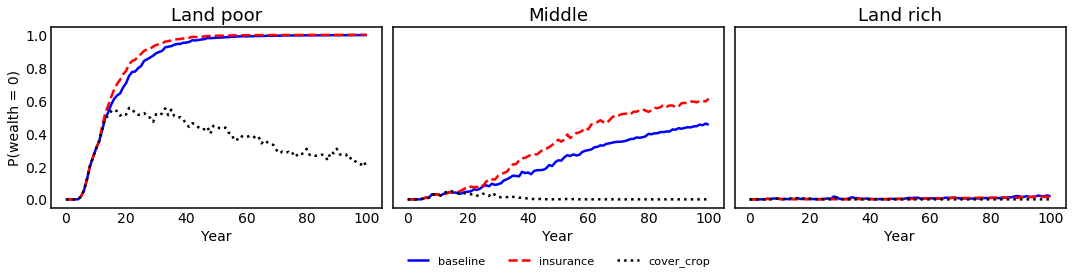

In [32]:
lands = inp_base['agents']['land_area_init']
titles = ['Land poor','Middle','Land rich']
lss = ['-','--',':']
fig, axs = plt.subplots(1,len(lands), figsize=(5*len(lands), 4), sharey=True)
for n, land_area in enumerate(lands):
    ss = 0
    for scenario, mods_sc in mods.items():
        ## calculate the wealth mean and std dev over time
        # extract and format the wealth info
        w = mods_sc['wealth']
        all_wealth = []
        for r in range(nreps):
            agents = mods_sc['land_area'][r] == land_area
            all_wealth.append(list(w[r,:,agents]))
        all_wealth = np.array([item for sublist in all_wealth for item in sublist])
        # ^ this is (agents, time) shape
        # extract mean and variance
        probs_t = np.mean(all_wealth<=0, axis=0)

        axs[n].plot(np.arange(T+1), probs_t, label=scenario, lw=2.5, ls=lss[ss])#, marker='o')
        ss += 1

for a, ax in enumerate(axs):
    ax.grid(False)
    ax.set_xlabel('Year')
    ax.set_title(titles[a])
axs[0].set_ylabel('P(wealth = 0)')
axs[1].legend(loc=10, bbox_to_anchor=(0.5, -0.3), ncol=3, frameon=False)
fig.tight_layout()

# sensitivity

In [11]:
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import os
import model.model as mod
import model.base_inputs as inp
import calibration.POM as POM
from experiments import multi_scenario_comparison as msc
# from experiments import analysis as shock
from experiments import sensitivity as senss
import code
import tqdm
import numpy as np
import pyDOE
import pickle
import pandas as pd
import copy
from joblib import Parallel, delayed
from tqdm import tqdm
import multiprocessing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import partial_dependence
import logging
import logging.config
# logging.config.fileConfig('logger.conf', defaults={'logfilename' : 'logs/{}.log'.format(os.path.basename(__file__)[:-3])})
# logger = logging.getLogger('sLogger')
sys.path.append('/home/twilliams/adaptation_abm/code/experiments')

In [12]:
exp_name = '2019_10_15_4'
N_vars = 1000 # number of random variable sets to generate
N_reps = 100 # number of times to repeat model for each variable set
ncores = 40
pom_nvars = 100000
pom_nreps = 10
n_mods = 1 # number of successful POM models
perturb_perc = 30
load = False
nboot_rf = 100
sens_vars = {
    'agents' : ['wealth_init_mean','cash_req_mean','livestock_cost','land_area_multiplier'],
    'land' : ['organic_N_min_init','max_organic_N','fast_mineralization_rate',
        'slow_mineralization_rate','loss_max','loss_min','max_yield',
        'rain_crit','rain_cropfail_low_SOM','random_effect_sd',
        'crop_CN_conversion','residue_CN_conversion',
        'wealth_N_conversion','livestock_frac_crops','livestock_residue_factor'],
    'climate' : ['rain_mu','rain_sd']
}

m=0
# logger.info('model {}........'.format(m))
### 1. load the POM variables
f = '../../outputs/{}/POM/{}_{}reps/input_params_{}.pkl'.format(exp_name, pom_nvars, pom_nreps, m)
inp_base = pickle.load(open(f, 'rb'))
# manually specify some variables (common to all scenarios)
inp_base['model']['n_agents'] = 200
inp_base['model']['exp_name'] = exp_name
inp_base['agents']['adap_type'] = 'always'
inp_base['agents']['land_area_multiplier'] = 1 # not in POM experiment

### 2. sample: generate random perturbed variable sets
params, keys, names = senss.hypercube_sample(N_vars, sens_vars, inp_base, perturb_perc)

### 3. run the policy analysis
T_shock = [10] # measured after the burn-in
T_res = [5]
shock_mag = [0.1]
inp_base['model']['T'] = T_shock[0] + T_res[0] + inp_base['adaptation']['burnin_period']
Ys = senss.calculate_QoI(exp_name, params, keys, names, inp_base, N_reps, ncores, T_shock, T_res, shock_mag, m, load)

### 4. run the random forest
var_imp_df, var_imp_list, pdp_data = senss.bootstrap_random_forest(Ys, params, names, keys, nboot_rf, load, exp_name, m)

FileNotFoundError: [Errno 2] No such file or directory: '../outputs/2019_10_15_4/model_0/sensitivity'

In [ ]:
### 5. plot results
plot_rf_results(var_imp_df, var_imp_list, pdp_data, Ys.mean(), exp_name, m)